(960, 960, 3)


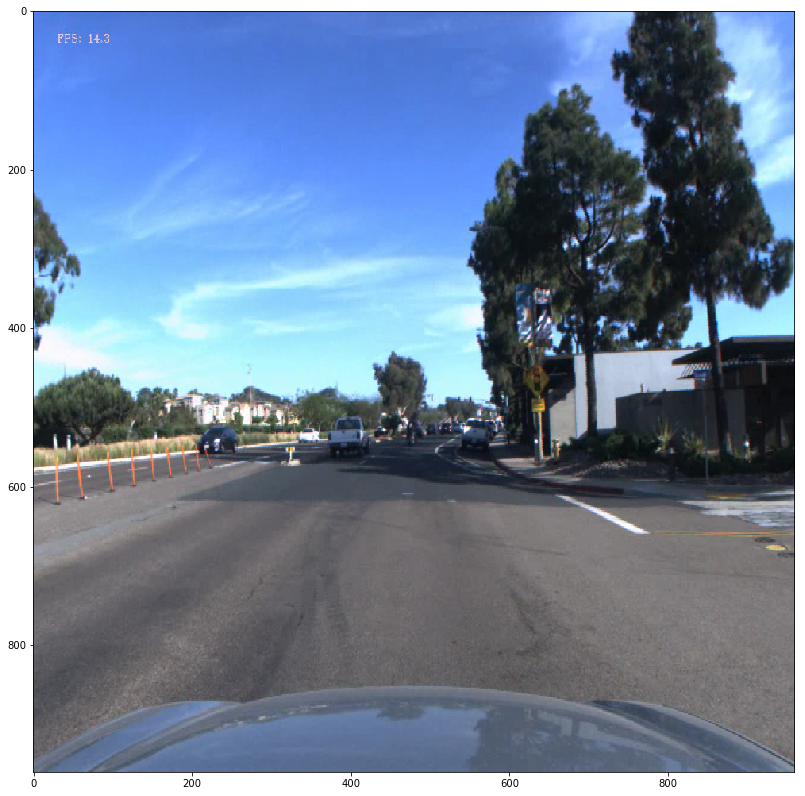

In [1]:
import cv2
import matplotlib.pyplot as plt
from utils.image_handler import preprocess_img
%matplotlib inline

path = '/home/ubuntu/dataset/lisa/training/2014-04-24_10-59/frameAnnotations-cam1.avi_annotations/pedestrianCrossing_1398812986.avi_image2.png'

original_img = cv2.cvtColor(cv2.imread('/home/ubuntu/dataset/lisa/training/2014-05-01_17-03/1/frameAnnotations-1.avi_annotations/signalAhead_1404947918.avi_image3.png'), cv2.COLOR_BGR2RGB)
img = cv2.resize(original_img, (960, 960))
# img = original_img
plt.figure(figsize=(14, 14))
plt.imshow(img)
print(img.shape)

In [8]:
from model.darknet19 import darknet19
from model.mobile_yolo import MobileYolo
import tensorflow as tf
import keras.backend as K
K.clear_session()  # to avoid duplicating model

with tf.device('/cpu:0'):
    yolov2     = MobileYolo(feature_extractor=darknet19(input_size=(None , None, 3)), 
                            num_anchors=5, 
                            num_classes=31, 
                            fine_grain_layer=43)
    model = yolov2.model
    model.load_weights('yolov2.weights')

In [9]:
# Preprocess input
from utils.image_handler import preprocess_img
from cfg import * 

input_img = preprocess_img(img)
input_img = np.expand_dims(input_img, 0)

# Making prediction
netout = model.predict(input_img)

netshape = np.shape(netout)
netout = np.reshape(netout, [-1, netshape[1], netshape[2], 5, N_CLASSES+5])

GRID_H, GRID_W = netout.shape[1:3]
height, width ,c  = img.shape
print(np.shape(netout))

(1, 30, 30, 5, 36)


In [10]:
import tensorflow as tf 
image_shape = img.shape
# Create GRID-cell map
cx = tf.cast((K.arange(0, stop=GRID_W)), dtype=tf.float32)
cx = K.tile(cx, [GRID_H])
cx = K.reshape(cx, [-1, GRID_H, GRID_W, 1])

cy = K.cast((K.arange(0, stop=GRID_H)), dtype=tf.float32)
cy = K.reshape(cy, [-1, 1])
cy = K.tile(cy, [1, GRID_W])  
cy = K.reshape(cy, [-1])    
cy = K.reshape(cy, [-1, GRID_H, GRID_W, 1])

c_xy = tf.stack([cx, cy], -1)
c_xy = tf.to_float(c_xy)

resized_anchors = ANCHORS * tf.cast([GRID_W, GRID_H], tf.float32)
anchors_tensor = tf.to_float(K.reshape(K.variable(resized_anchors), [1, 1, 1, 5, 2]))
netout_size   = tf.to_float(K.reshape([GRID_W, GRID_H], [1, 1, 1, 1, 2]))

box_xy          = K.sigmoid(netout[..., :2])
box_wh          = K.exp(netout[..., 2:4])
box_confidence  = K.sigmoid(netout[..., 4:5])
box_class_probs = K.softmax(netout[..., 5:])

# Adjust predictions to each spatial grid point and anchor size.
box_xy = (box_xy + c_xy) / netout_size
box_wh = box_wh * anchors_tensor / netout_size
box_mins  = box_xy - (box_wh / 2.)
box_maxes = box_xy + (box_wh / 2.)

# Y1, X1, Y2, X2
boxes   = K.concatenate([box_mins[..., 1:2], box_mins[..., 0:1],  box_maxes[..., 1:2], box_maxes[..., 0:1]])

box_scores       = box_confidence * box_class_probs
box_classes      = K.argmax(box_scores, -1)
box_class_scores = K.max(box_scores, -1)
prediction_mask  = (box_class_scores >= 0.2)

boxes   = tf.boolean_mask(boxes, prediction_mask)
scores  = tf.boolean_mask(box_class_scores, prediction_mask)
classes = tf.boolean_mask(box_classes, prediction_mask)

# Scale boxes back to original image shape.
height = image_shape[0]
width = image_shape[1]

image_dims = tf.cast(K.stack([height, width, height, width]), tf.float32)
image_dims = K.reshape(image_dims, [1, 4])
boxes = boxes * image_dims

nms_index = tf.image.non_max_suppression(boxes, scores, tf.Variable(10), iou_threshold=0.5)
boxes = K.gather(boxes, nms_index)
scores = K.gather(scores, nms_index)
classes = K.gather(classes, nms_index)


with tf.Session() as sess:   
    tf.global_variables_initializer().run()
    boxes_prediction = boxes.eval()
    scores_prediction = scores.eval()
    classes_prediction = classes.eval()

print(boxes_prediction, scores_prediction, classes_prediction)

(array([[ 263.42745972,  695.54602051,  355.73419189,  757.45825195]], dtype=float32), array([ 0.96624035], dtype=float32), array([1]))


Found a 'bicyclesMayUseFullLane' at (927.39469401041663, 263.42745971679688, 1009.9443359375, 355.73419189453125) with 96.624035%
(960, 960, 3)


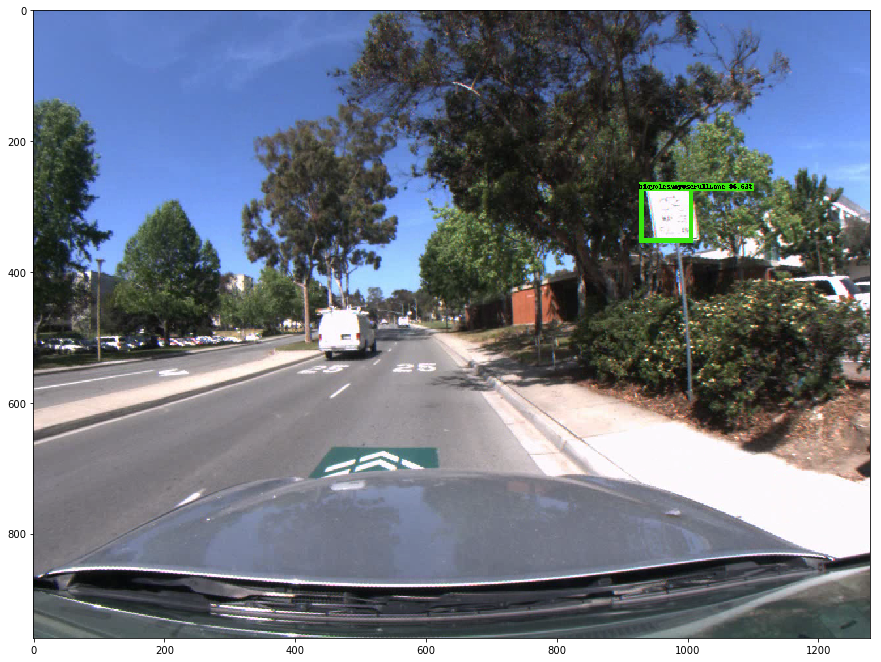

In [11]:
from utils.draw_boxes import Box, draw
result = boxes_prediction
bboxes = []

orig_size = original_img.shape
for box, score, cls in zip(result, scores_prediction, classes_prediction):
    box = box * np.array(2 *[orig_size[0]/960., orig_size[1]/960.])
    y1, x1, y2, x2 = box
    print("Found a '{}' at {} with {:-2f}%".format(CATEGORIES[cls], (x1, y1, x2, y2), 100*score))
    bboxes.append(Box(x1, y1, x2, y2, CATEGORIES[cls], score))

result = draw(original_img, bboxes)
plt.figure(figsize=(15, 15))

plt.imshow(result)
print(img.shape)